# Hacking together an initial dataset

Adapted from Ryan's notebook from Oct 23, 2024.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
waived_df = pd.read_csv("Data/player_identification/waived_data_with_id.csv")
stats_df = pd.read_csv("Data/season_counting_stats.csv")

In [3]:
#look at columns
print(waived_df.columns)
print(stats_df.columns)

Index(['season_start', 'date', 'player_name', 'team_abv', 'player_id'], dtype='object')
Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'NAME', 'SEASON_START'],
      dtype='object')


In [4]:
#rename waived_df columns player_id, season_start, team_abv so that they agree with stats_df;
#do this in-place
waived_df.rename(columns={'player_id':'PLAYER_ID', 'season_start':'SEASON_START', 'team_abv': 'TEAM_ABBREVIATION'}, inplace = True)

#check that it worked
print(waived_df.columns)

Index(['SEASON_START', 'date', 'player_name', 'TEAM_ABBREVIATION',
       'PLAYER_ID'],
      dtype='object')


In [5]:
#merge stats_df and waived_df on PLAYER_ID, SEASON_START, TEAM_ABBREVIATION
merged_df = pd.merge(stats_df, waived_df, on=['PLAYER_ID', 'SEASON_START', 'TEAM_ABBREVIATION'], how='left')

In [6]:
#pick an example of a player who was waived and show the date they were waived
merged_df.loc[merged_df['PLAYER_ID'] == 192][["SEASON_START", "NAME", "date"]]

,SEASON_START,NAME,date
1477,1990,Dennis Scott,NaN
1478,1991,Dennis Scott,NaN
1479,1992,Dennis Scott,NaN
1480,1993,Dennis Scott,NaN
1481,1994,Dennis Scott,NaN
1482,1995,Dennis Scott,NaN
1483,1996,Dennis Scott,NaN
1484,1997,Dennis Scott,NaN
1485,1997,Dennis Scott,NaN
1486,1997,Dennis Scott,NaN


In [7]:
#make a new column called WAIVED and set it to zero
merged_df['WAIVED'] = 0

#if player was waived in a given row, their date column is not null; set those cases to 1
merged_df.loc[merged_df['date'].notnull(), 'WAIVED'] = 1

In [8]:
#check that this worked for player 192
merged_df.loc[merged_df['PLAYER_ID'] == 192][["SEASON_START", "NAME", "date", "WAIVED"]]

,SEASON_START,NAME,date,WAIVED
1477,1990,Dennis Scott,NaN,0
1478,1991,Dennis Scott,NaN,0
1479,1992,Dennis Scott,NaN,0
1480,1993,Dennis Scott,NaN,0
1481,1994,Dennis Scott,NaN,0
1482,1995,Dennis Scott,NaN,0
1483,1996,Dennis Scott,NaN,0
1484,1997,Dennis Scott,NaN,0
1485,1997,Dennis Scott,NaN,0
1486,1997,Dennis Scott,NaN,0


## making `WAIVED_THIS_SEASON` row

We'll eventually want to convert the dataframe from "player-season-team" format to "player-season" format, and we'll need to know if a player was waived at all during a given season.  As a first step, make a column called `WAIVED_THIS_SEASON`.

In [9]:
#grab a portion of the waived dataframe with just PLAYER_ID and SEASON_START data for waived players
waived_tuples = waived_df[["PLAYER_ID", "SEASON_START"]]

#make a hash set of tuples (PLAYER_ID, SEASON_START) corresponding to players who are moved.
#we could use a list instead of a hash set, but the stuff below would be much slower
waived_set = set(tuple(x) for x in waived_tuples.to_numpy())

In [10]:
#see: https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe
merged_df["WAIVED_THIS_SEASON"] = merged_df.apply(lambda x: int((x.PLAYER_ID, x.SEASON_START) in waived_set), axis=1)

In [11]:
#check that it worked using PLAYER_ID=192
merged_df.loc[merged_df['PLAYER_ID'] == 192][["SEASON_START", "NAME", "date", "WAIVED", "WAIVED_THIS_SEASON"]]

,SEASON_START,NAME,date,WAIVED,WAIVED_THIS_SEASON
1477,1990,Dennis Scott,NaN,0,0
1478,1991,Dennis Scott,NaN,0,0
1479,1992,Dennis Scott,NaN,0,0
1480,1993,Dennis Scott,NaN,0,0
1481,1994,Dennis Scott,NaN,0,0
1482,1995,Dennis Scott,NaN,0,0
1483,1996,Dennis Scott,NaN,0,0
1484,1997,Dennis Scott,NaN,0,0
1485,1997,Dennis Scott,NaN,0,0
1486,1997,Dennis Scott,NaN,0,0


## putting the dataframe in "player-season" format

- Go through all rows with TEAM_ABBREVIATION TOT, add those to set of tuples (PLAYER_ID, SEASON_START)
- drop all rows which are not TOT and have (PLAYER_ID, SEASON_START) in our set of tuples

In [12]:
#grab dataframe of all "TOT" rows
TOT_seasons = merged_df[merged_df["TEAM_ABBREVIATION"]=="TOT"]

In [13]:
#go through TOT rows and grab just PLAYER_ID, SEASON_START data
tot_tuples = TOT_seasons[["PLAYER_ID", "SEASON_START"]]

#package tuples of (PLAYER_ID, SEASON_START) into a set; note that this could be a list, but the
#stuff below would be much slower
tot_tuples_set = set(tuple(x) for x in tot_tuples.to_numpy())

In [14]:
#we want to keep the rows that are already in player-season format (rather than player-season-team)

#keep rows (return True) when TEAM_ABBREVIATION=="TOT" or (PLAYER_ID, SEASON_START) not in tot_tuples_set.
#In other words, the rows we're keeping are either TOT rows or have a (PLAYER_ID, SEASON_START) tuples which
#never appears as a TOT row (i.e. it's a season where the player is never moved)
def find_keep_rows(x):
    is_tot_row       = x.TEAM_ABBREVIATION == "TOT"
    player_not_moved = (x.PLAYER_ID, x.SEASON_START) not in tot_tuples_set
    return is_tot_row or player_not_moved

In [15]:
#apply the function and save the result as "KEEP_ROW", which will be True for rows we want
#(which are already in player-season format) and False for rows we're going to drop
merged_df["KEEP_ROW"] = merged_df.apply(find_keep_rows, axis=1)

In [16]:
#check that this worked for PLAYER_ID == 192.  Note that this worked: KEEP_ROW is True for all rows
#corresponding to a season where Dennis Scott was not moved, or the TOT row in seasons where he was moved
merged_df[merged_df["PLAYER_ID"]==192][["NAME", "TEAM_ABBREVIATION", "SEASON_START", "KEEP_ROW"]]

,NAME,TEAM_ABBREVIATION,SEASON_START,KEEP_ROW
1477,Dennis Scott,ORL,1990,True
1478,Dennis Scott,ORL,1991,True
1479,Dennis Scott,ORL,1992,True
1480,Dennis Scott,ORL,1993,True
1481,Dennis Scott,ORL,1994,True
1482,Dennis Scott,ORL,1995,True
1483,Dennis Scott,ORL,1996,True
1484,Dennis Scott,DAL,1997,False
1485,Dennis Scott,PHX,1997,False
1486,Dennis Scott,TOT,1997,True


In [17]:
#make the dataframe in player_season format; this is easy, since we just want the places where
#KEEP_ROW = True
PS_df = merged_df[merged_df["KEEP_ROW"]]

## clean up dataframe a bit

We have a bunch of columns that aren't very useful (e.g. `TEAM_ID`); let's drop those.

In [18]:
print(PS_df.columns)

Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'NAME', 'SEASON_START', 'date',
       'player_name', 'WAIVED', 'WAIVED_THIS_SEASON', 'KEEP_ROW'],
      dtype='object')


In [19]:
PS_df_clean = PS_df.drop(columns=["SEASON_ID", "LEAGUE_ID", "TEAM_ID", "date", "player_name", "WAIVED", "KEEP_ROW"])

## Putting in a `WAIVED_NEXT_SEASON` column

The `WAIVED_NEXT_SEASON` value will be the response variable for our model.  The idea here is to make a hash set of tuples called `waived_seasons` with the format `(PLAYER_ID, SEASON_START)`.  We will then check if `(PLAYER_ID, SEASON_START+1)` is in `waived_seasons`; if it is, then `WAIVED_NEXT_SEASON` is `1` and otherwise it is `0`.

In [20]:
#for seasons where the player was waived, grab their PLAYER_ID and SEASON_START
waived_df = PS_df_clean[PS_df_clean["WAIVED_THIS_SEASON"]==1][["PLAYER_ID", "SEASON_START"]]

#package (PLAYER_ID, SEASON_START) tuples into a hash set
waived_seasons = set(tuple(x) for x in waived_df.to_numpy())

In [21]:
#define a function that returns 1 if the player was waived in the next season
#and 0 otherwise
def waived_next_season(x):
    res_boolean = (x.PLAYER_ID, x.SEASON_START+1) in waived_seasons
    return int( res_boolean )

In [22]:
#apply waived_next_season to the dataframe
PS_df_clean["WAIVED_NEXT_SEASON"] = PS_df_clean.apply(waived_next_season, axis=1)

In [23]:
#check that it works with PLAYER_ID=192
PS_df_clean[PS_df_clean["PLAYER_ID"]==192]

,PLAYER_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,...,AST,STL,BLK,TOV,PF,PTS,NAME,SEASON_START,WAIVED_THIS_SEASON,WAIVED_NEXT_SEASON
1477,192,ORL,22.0,82,73.0,2336.0,503,1183,0.425,125.0,...,134,62.0,25.0,127.0,203,1284,Dennis Scott,1990,0,0
1478,192,ORL,23.0,18,15.0,608.0,133,331,0.402,29.0,...,35,20.0,9.0,31.0,49,359,Dennis Scott,1991,0,0
1479,192,ORL,24.0,54,43.0,1759.0,329,763,0.431,108.0,...,136,57.0,18.0,104.0,131,858,Dennis Scott,1992,0,0
1480,192,ORL,25.0,82,37.0,2283.0,384,949,0.405,155.0,...,216,81.0,32.0,93.0,161,1046,Dennis Scott,1993,0,0
1481,192,ORL,26.0,62,10.0,1499.0,283,645,0.439,150.0,...,131,45.0,14.0,57.0,119,802,Dennis Scott,1994,0,0
1482,192,ORL,27.0,82,82.0,3041.0,491,1117,0.440,267.0,...,243,90.0,29.0,122.0,169,1431,Dennis Scott,1995,0,0
1483,192,ORL,28.0,66,62.0,2166.0,298,749,0.398,147.0,...,139,74.0,19.0,81.0,138,823,Dennis Scott,1996,0,0
1486,192,TOT,29.0,81,45.0,2290.0,329,828,0.397,125.0,...,153,53.0,39.0,104.0,152,888,Dennis Scott,1997,0,1
1489,192,TOT,30.0,36,9.0,738.0,87,213,0.408,37.0,...,40,15.0,3.0,19.0,49,234,Dennis Scott,1998,1,0
1490,192,VAN,31.0,66,0.0,1263.0,125,333,0.375,71.0,...,69,28.0,9.0,30.0,104,369,Dennis Scott,1999,0,0


# Visualizing the player-season data

Let's now do some basic visualization of the reformatted dataframe `PS_df_clean` (player-season format).

Let's start by seeing how many players actually were waived in the following season.

In [24]:
#start by checking how the WAIVED_NEXT_SEASON column (our response variable) turned out
num_waived_next = PS_df_clean["WAIVED_NEXT_SEASON"].sum()
total_rows      = len(PS_df_clean)

print(f"Out of the {total_rows} players, {num_waived_next} ({num_waived_next/total_rows*100:.2f}%) were waived next season")

Out of the 24688 players, 1476 (5.98%) were waived next season


### Correlations between features/response

Let's now make the correlation heatmap between features and the response variable `WAIVED_NEXT_SEASON`.

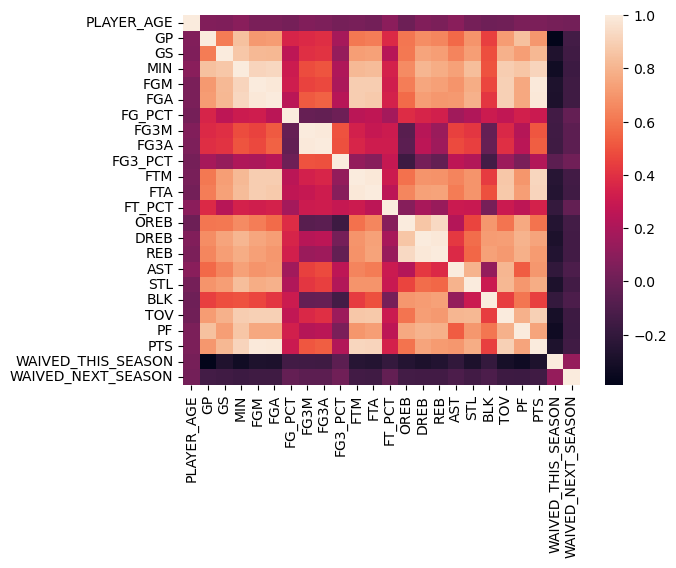

In [31]:
features_and_response = ['PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
                         'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
                         'BLK', 'TOV', 'PF', 'PTS', 'WAIVED_THIS_SEASON', 'WAIVED_NEXT_SEASON']

corr = PS_df_clean[features_and_response].corr()

sns.heatmap(corr)
plt.show()

It looks like correlations with `WAIVED_NEXT_SEASON` are pretty weak.  The numerical results are printed in the next cell.  Notice that the largest magnitude correlation is `PF`, which is around $-0.17$.

In [33]:
corr["WAIVED_NEXT_SEASON"]

PLAYER_AGE            0.020876
GP                   -0.140066
GS                   -0.151379
MIN                  -0.165905
FGM                  -0.155012
FGA                  -0.155763
FG_PCT               -0.027429
FG3M                 -0.054648
FG3A                 -0.053981
FG3_PCT               0.012005
FTM                  -0.148397
FTA                  -0.151790
FT_PCT               -0.035035
OREB                 -0.143213
DREB                 -0.145884
REB                  -0.143957
AST                  -0.109390
STL                  -0.146620
BLK                  -0.111158
TOV                  -0.162573
PF                   -0.170006
PTS                  -0.152923
WAIVED_THIS_SEASON    0.128836
WAIVED_NEXT_SEASON    1.000000
Name: WAIVED_NEXT_SEASON, dtype: float64

### Plotting distributions where `WAIVED_THIS_SEASON` is `0` or `1`

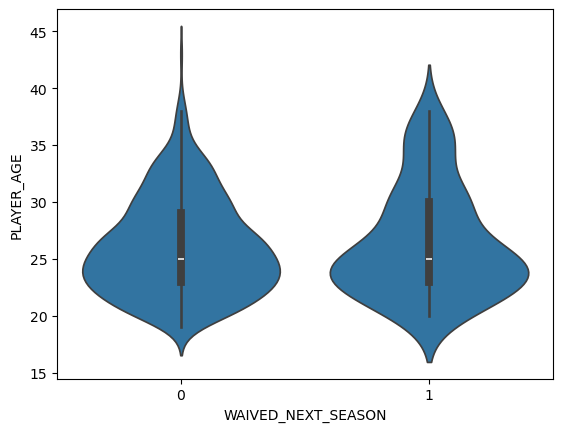

In [36]:
#write a helper function to visualize the stat differences between those who were waived next season
#vs those who weren't
def compare_waived_plot(season_start, stat):
    sns.violinplot(data=PS_df_clean[PS_df_clean["SEASON_START"]==season_start], x="WAIVED_NEXT_SEASON", y=stat)
    plt.show()

#grab all of the different stats and put them in a list
stats_types = ['PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
               'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
               'BLK', 'TOV', 'PF', 'PTS']

#make a violinplot for each stat.  Limiting this to 0:1 to de-clutter notebook
for stat in stats_types[0:1]:
    compare_waived_plot(2022, stat)